## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [2]:
# cd ..
%cd /home/jovyan/dea_intertidal/dea-intertidal

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [3]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


### Load packages

In [4]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
import odc.geo.xr
from tqdm import tqdm
from odc.algo import mask_cleanup, xr_quantile
from concurrent.futures import ProcessPoolExecutor

from dea_tools.dask import create_local_dask_cluster
from dea_tools.coastal import pixel_tides, model_tides
from intertidal.elevation import (load_data, 
                                  ds_to_flat, 
                                  pixel_rolling_median,
                                  pixel_dem,
                                  elevation
                                 )
from intertidal.extents import extents
from intertidal.utils import load_config
from intertidal.exposure import pixel_exp
from intertidal.tidal_bias_offset import bias_offset
from intertidal.tidelines import tidal_offset_tidelines

# cluster = create_dask_gateway_cluster(profile="r5_4XL", workers=10)
# print("Dashboard", cluster.dashboard_link)
# client = cluster.get_client()

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

# Connect to datacube
dc = datacube.Datacube(app='Intertidal_elevation')

2023-03-27 10:01:06,167 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-xlj31shs', purging
2023-03-27 10:01:06,167 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-qha9efey', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 94,Total memory: 697.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40535,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 94
Started: Just now,Total memory: 697.21 GiB
Comm: tcp://127.0.0.1:43809,Total threads: 94
Dashboard: /user/claire.phillips@ga.gov.au/proxy/45603/status,Memory: 697.21 GiB
Nanny: tcp://127.0.0.1:33725,


## Setup


### Set analysis parameters

In [5]:
study_area = 'Roebuck_WA'#1215 #340
## 815: South Gladstone, QLD 

## Nidem variables
fname = 'testing_RoebuckWA'
start_year = 2019
end_year = 2021
resolution = 10 
crs = "epsg:32753"
ndwi_thresh = 0.1
include_s2 = True
include_ls = True
filter_gqa = False

## Exposure variables
## Tidal modelling period. Format: 'YYYY-MM-DD HH:MM:SS'
time_start = '2019-01-01 00:00:00'
time_end = '2021-12-31 00:00:00'

## Set the frequency to run the tidal model e.g '30min' or '1h'
modelled_freq='30min'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(start=time_start,
                              end=time_end,
                              freq=modelled_freq)

# Load analysis params from config file
config = load_config(
    config_path='configs/dea_intertidal_config.yaml')

### Load study area grid cell

In [6]:
# # Albers grid cells used to process the analysis
# gridcell_gdf = (
#     gpd.read_file(config['Input files']['grid_path']).to_crs(
#         epsg=4326).set_index('id'))
# gridcell_gdf.index = gridcell_gdf.index.astype(int).astype(str)
# gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]

# # Create geom as input for dc.load
# geom = Geometry(geom=gridcell_gdf.iloc[0].geometry, crs='EPSG:4326')
# geom

##### Other options for loading study area

In [7]:
# # aoi = 'McCarthur River'
# # aoi = 'Greenbank'
# aoi = 'Seven Emu'
# # aoi = 'Wollogorang'

# # Import regions of interest
# aoi_gdf = gpd.read_file('data/raw/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
# aoi_gdf.head()

# # Select AOI
# geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
# geom

In [8]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                       
                             zoom=4)

## Guide: for 10m2 pixels, analysis area of 90km2 takes ~XXXX mins to run full workflow on 16XL sandbox instance

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

# Elevation

In [9]:
ds = elevation(study_area=geom,
               start_year = start_year,
               end_year = end_year)

/env/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42899 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/42899/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/42899/status,Workers: 1
Total threads: 94,Total memory: 697.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45131,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/42899/status,Total threads: 94
Started: Just now,Total memory: 697.21 GiB
Comm: tcp://127.0.0.1:41255,Total threads: 94
Dashboard: /user/claire.phillips@ga.gov.au/proxy/39745/status,Memory: 697.21 GiB
Nanny: tcp://127.0.0.1:34867,


2023-03-27 10:01:56 INFO Study area testing: Loaded custom study area
2023-03-27 10:01:56 INFO Study area testing: Loading satellite data
2023-03-27 10:13:17 INFO Study area testing: Modelling tide heights for each pixel


Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 471/471 [01:23<00:00,  5.65it/s]
2023-03-27 10:15:27 INFO Study area testing: Masking nodata and adding tide heights to satellite data array
2023-03-27 10:16:12 INFO Study area testing: Flattening satellite data array and filtering to tide influenced pixels
2023-03-27 10:20:15 INFO Study area testing: Running per-pixel rolling median


Reducing analysed pixels from 17930126 to 1627207 (9.08%)


100%|██████████| 114/114 [34:37<00:00, 18.22s/it]
2023-03-27 10:55:39 INFO Study area testing: Modelling intertidal elevation and confidence


Processing dem_low
Processing dem
Processing dem_high


/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-03-27 10:55:54 INFO Study area testing: Successfully completed intertidal elevation modelling


# Intertidal extents

## Always/Sometimes/Never_wet

Values of 0 represent always wet, 1 is the extent of the DEA intertidal product suite and 2 represents never wet

In [ ]:
ds = extents(ds)

# Pixel-based intertidal exposure
Calculate exposure using the script function

In [ ]:
ds = pixel_exp(ds, all_timerange)

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 101/101 [00:37<00:00,  2.66it/s]


# Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [ ]:
ds = bias_offset(ds,                 
                 # set_dtype=np.int16,
                 LAT_HAT=True,
                 LOT_HOT=True)

# Tideline confidence

In [ ]:
hightideline, lowtideline, tidelines_gdf = tidal_offset_tidelines(ds, distance=250)

Operating in multiple z-value, single array mode


In [ ]:
ds

<xarray.Dataset>
Dimensions:      (time: 471, y: 4798, x: 3737, quantile: 101)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T01:55:10.045362 ... 2021-12...
  * y            (y) float64 -1.95e+06 -1.95e+06 ... -1.998e+06 -1.998e+06
  * x            (x) float64 -1.047e+06 -1.047e+06 ... -1.009e+06 -1.009e+06
    spatial_ref  int32 3577
    variable     <U4 'ndwi'
  * quantile     (quantile) float64 0.0 0.01 0.02 0.03 ... 0.97 0.98 0.99 1.0
Data variables: (12/17)
    ndwi         (time, y, x) float32 nan nan nan ... -0.4444 -0.4366 -0.4386
    tide_m       (time, y, x) float32 nan nan nan nan ... -1.031 -1.031 -1.031
    freq         (y, x) float64 0.9926 0.9926 0.9963 1.0 ... 0.0 0.0 0.0 0.0
    dem_low      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    dem          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    dem_high     (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    ...           ...
    HAT          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    LOT          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    HOT          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    spread       (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    ht_offset    (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    lt_offset    (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

# Plot all layers

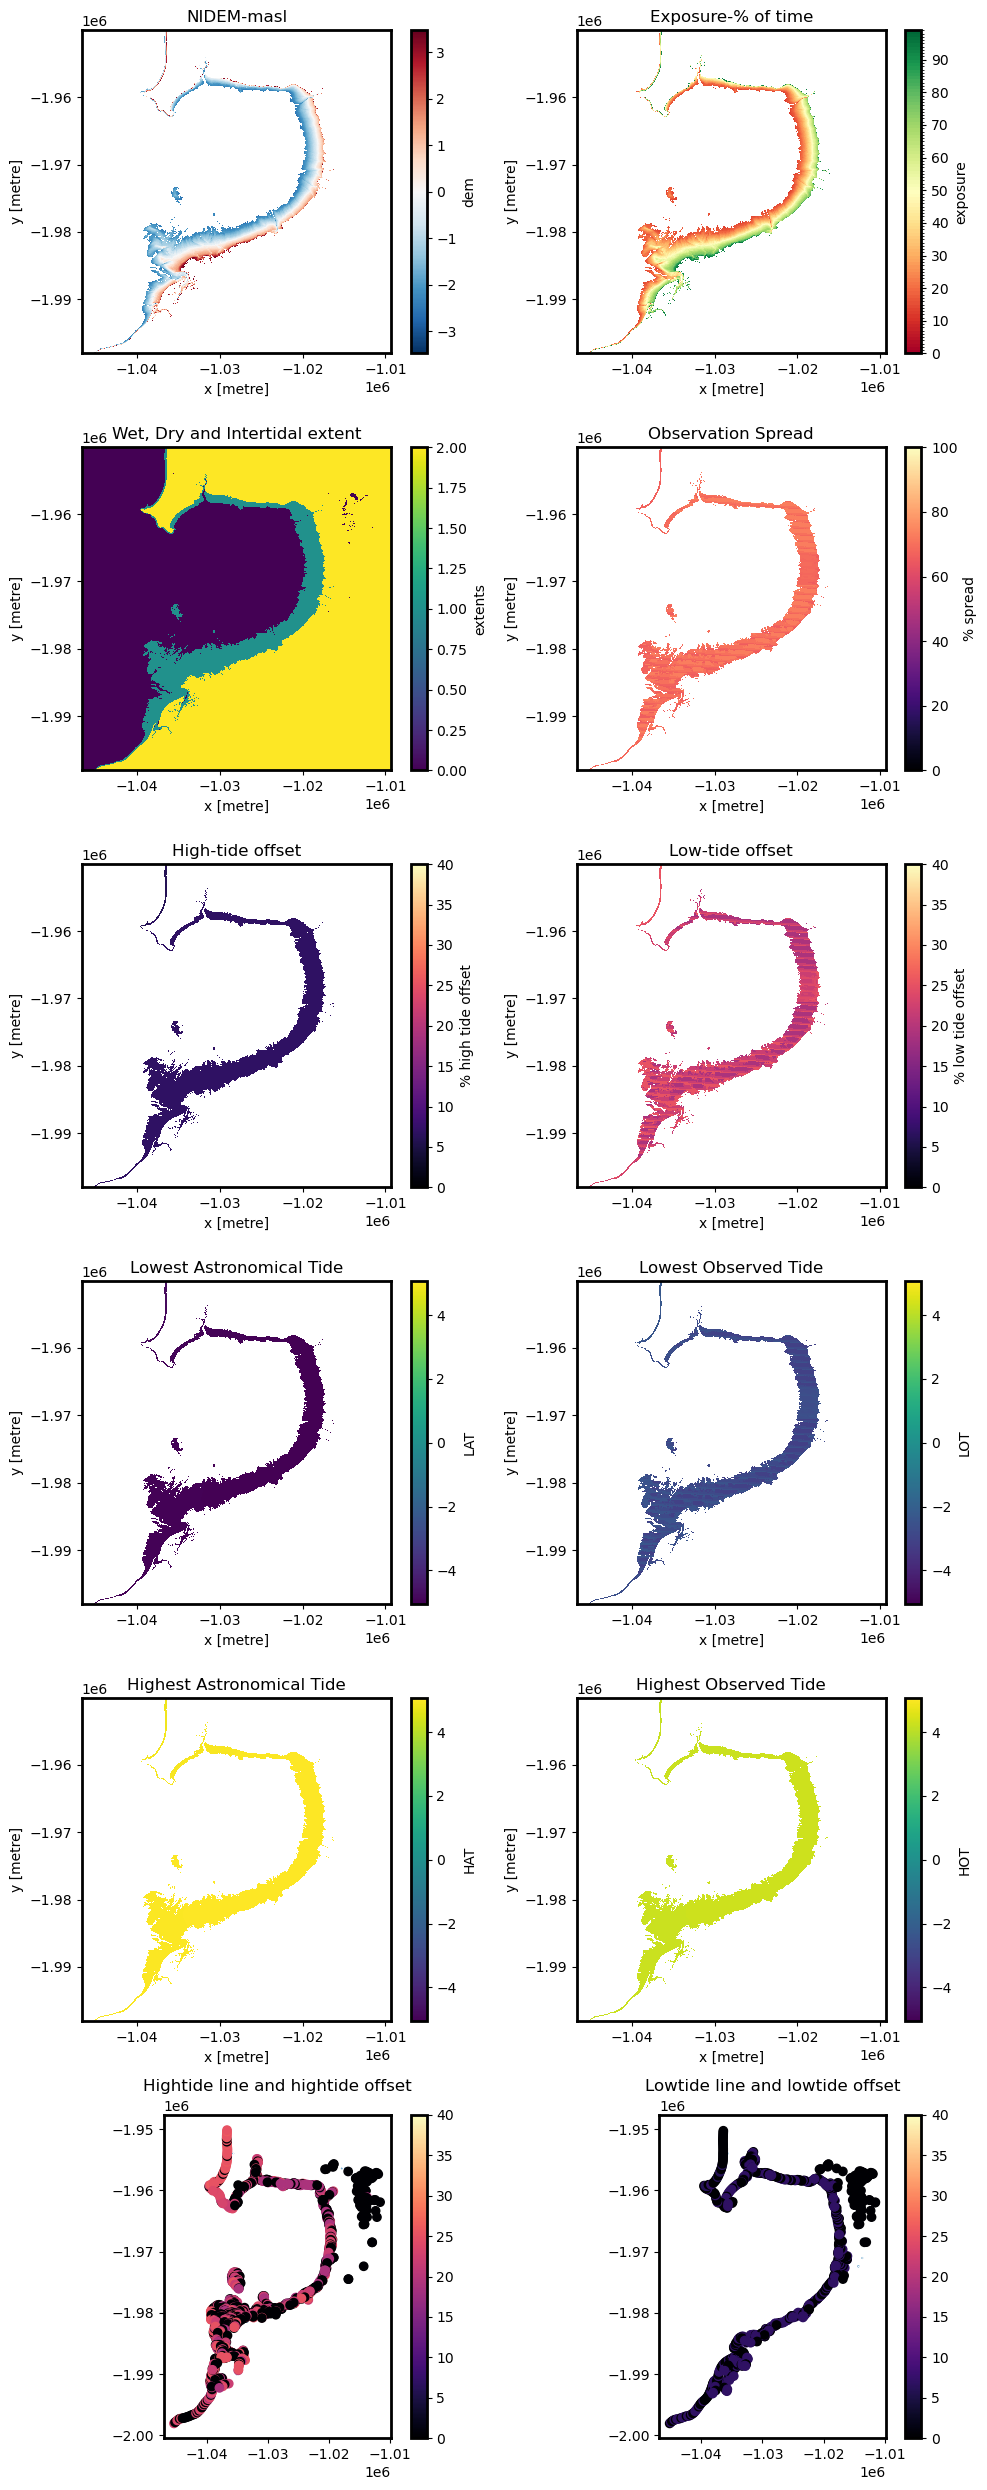

In [ ]:
fig = plt.figure(figsize=(10,25))
ax1 = fig.add_subplot(6,2,1)
ax2 = fig.add_subplot(6,2,2)
ax3 = fig.add_subplot(6,2,3)
ax4 = fig.add_subplot(6,2,4)
ax5 = fig.add_subplot(6,2,5)
ax6 = fig.add_subplot(6,2,6)
ax7 = fig.add_subplot(6,2,7)
ax8 = fig.add_subplot(6,2,8)
ax9 = fig.add_subplot(6,2,9)
ax10 = fig.add_subplot(6,2,10)
ax11 = fig.add_subplot(6,2,11)
ax12 = fig.add_subplot(6,2,12)

## Plot NIDEM
ds['dem'].plot(ax=ax1)
ax1.set_title('NIDEM-masl')

## Plot Exposure
ds['exposure'].where(ds['exposure']>0).plot(ax=ax2, cmap='RdYlGn', levels=np.arange(0,100,1))
ax2.set_title('Exposure-% of time')

## Plot the always/sometimes/never wet extents
ds['extents'].astype(np.int16).plot(ax=ax3)
ax3.set_title('Wet, Dry and Intertidal extent')

## Plot the observation spread
ds['spread'].where((ds['extents']!=2) & (ds['spread'] > 0)).plot(ax=ax4, vmin=0, vmax=100, cmap='magma', cbar_kwargs={'label': '% spread'})
ax4.set_title('Observation Spread')

## Plot the high-tide offset
ds['ht_offset'].where((ds['extents']!=2) & (ds['spread'] > 0)).plot(ax=ax5, vmin=0, vmax=40, cmap='magma', cbar_kwargs={'label': '% high tide offset'})
ax5.set_title('High-tide offset')

## Plot the low-tide offset
ds['lt_offset'].where((ds['extents']!=2) & (ds['spread'] > 0)).plot(ax=ax6, vmin=0, vmax=40, cmap='magma', cbar_kwargs={'label': '% low tide offset'})
ax6.set_title('Low-tide offset')

## Plot the LAT
ds['LAT'].where(ds['extents']!=2).plot(ax=ax7, vmin=ds['LAT'].min(), vmax=ds['HAT'].max())
ax7.set_title('Lowest Astronomical Tide')

## Plot the LOT
ds['LOT'].where(ds['extents']!=2).plot(ax=ax8, vmin=ds['LAT'].min(), vmax=ds['HAT'].max())
ax8.set_title('Lowest Observed Tide')

## Plot the HAT
ds['HAT'].where(ds['extents']!=2).plot(ax=ax9, vmin=ds['LAT'].min(), vmax=ds['HAT'].max())
ax9.set_title('Highest Astronomical Tide')

## Plot the HOT
ds['HOT'].where(ds['extents']!=2).plot(ax=ax10, vmin=ds['LAT'].min(), vmax=ds['HAT'].max())
ax10.set_title('Highest Observed Tide')

## Plot the high and low tidelines with respective offset
ax11.set_title('Lowtide line and lowtide offset')
lowtideline.plot(column='lt_offset', legend=True, vmin=0, vmax=40, cmap='magma', ax=ax11, zorder=2)
tidelines_gdf.loc[[0], 'geometry'].plot(ax=ax11, zorder=1)

ax12.set_title('Hightide line and hightide offset')
hightideline.plot(column='ht_offset', legend=True, vmin=0, vmax=40, cmap='magma', ax=ax12, zorder=2)
tidelines_gdf.loc[[1], 'geometry'].plot(ax=ax12, zorder=1)

fig.tight_layout()
plt.show()

# Export layers

In [ ]:
## select layers of interest from ds
ds1 = xr.Dataset(data_vars = ds[['dem','confidence','extents','exposure','spread','lt_offset','ht_offset','LAT','HAT','LOT','HOT']],
                coords = ds.coords,
                attrs = ds.attrs)

## Save layers as geotiffs
ds1.map(
    lambda x: x.odc.write_cog(
        fname=f"data/interim/pixel_{fname}_{x.name}.tif", overwrite=True
    )
) 

hightideline.to_file('data/interim/Roebuck_south_WA_hightideoffset.shp')
lowtideline.to_file('data/interim/Roebuck_south_WA_lowtideoffset.shp')
tidelines_gdf.to_file('data/interim/Roebuck_south_WA_high_0_low_1_tidelines.shp')

In [21]:
import fiona
from shapely.geometry import mapping

schema = {
    'geometry': 'Polygon',
    'properties':{'id':'int'}
    }

with fiona.open('./Roebuck_Bay_geom', 'w', 'ESRI Shapefile', schema) as c:
    c.write({'geometry': mapping(geom.geom),
             'properties':{'id':123},
            })

,z_value,geometry
0,0.5,"MULTILINESTRING ((-1045310.000 -1998045.000, -..."
1,1.5,"MULTILINESTRING ((-1045150.000 -1998045.000, -..."
